In [5]:
import torch
import torchvision
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Split the dataset into training and test sets
train_data, test_data = train_test_split(trainset, test_size=0.2, random_state=42)

# Create data loaders for training and test sets
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

Each picture has 28*28 pixels. 
Intotal 60000 pictures.
Learning rate 0.01, each batch takes 64 pictures. 
How many epochs should we set?

In [13]:
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def train_model_once(model,device,epoch,lr):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    loss_record = []
    running_loss = 0.0    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            with open(f'log/{model.__class__.__name__}_log_train.txt', 'a') as f:
                f.write(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}\n')
            loss_record.append(running_loss / 100)
            running_loss = 0.0
    return loss_record

def test_model(model,device,epoch):
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over the test data
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            _, predicted = torch.max(model(inputs), 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Compute metrics
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    with open(f'log/{model.__class__.__name__}_log_test.txt', 'a') as f:
        f.write(f'[ Epoch {epoch + 1} ]: ')
        f.write(f'Precision: {precision:.4f}\t')
        f.write(f'Recall: {recall:.4f}\t')
        f.write(f'F1 Score: {f1:.4f}\n')
    #print(conf_matrix)
    return precision, recall, f1, conf_matrix

def run(model_class):
    model = model_class()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'training models on {device}')
    
    loss_history = []
    metric_history = []
    for epoch in tqdm(range(20)):  # loop over the dataset multiple times
        loss_record = train_model_once(model,device,epoch,lr=0.01)
        loss_history.append(loss_record)
        metric_record = test_model(model,device,epoch)
        metric_history.append(metric_record)
    return loss_history, metric_history

import matplotlib.pyplot as plt

def plot_metric(metric_history):
    precision = [m[0] for m in metric_history]
    recall = [m[1] for m in metric_history]
    f1 = [m[2] for m in metric_history]
    plt.plot(precision, label='Precision')
    plt.plot(recall, label='Recall')
    plt.plot(f1, label='F1')
    plt.legend(['Precision', 'Recall', 'F1'])

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # print(x.shape)
        x = self.dropout1(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc1(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # print(x.shape)
        output = F.log_softmax(x, dim=1)
        return output

training models on  cuda


c:\Users\bingy\anaconda3\envs\num-embeddings\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bingy\anaconda3\envs\num-embeddings\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bingy\anaconda3\envs\num-embeddings\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bingy\anaconda3\envs\num-

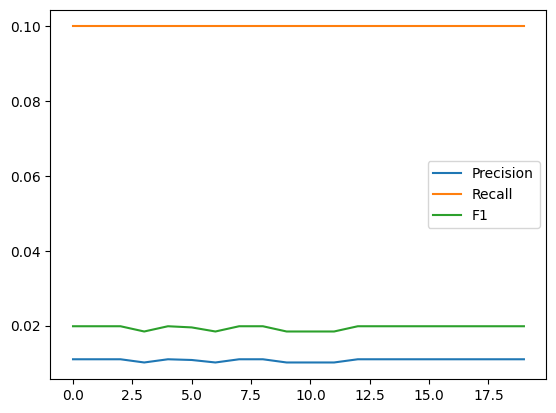

In [ ]:
loss_history,metric_history = run(CNN)
plot_metric(metric_history=metric_history)
loss_history,metric_history = run(CNN)
plot_metric(metric_history=metric_history)

### Important convolutional based NNs

In [9]:
# AlexNet 

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

In [10]:
# Resnet    
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or planes != 64:
            downsample = nn.Sequential(
                nn.Conv2d(64, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(BasicBlock(64, planes, stride, downsample))
        for _ in range(1, blocks):
            layers.append(BasicBlock(planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)